In [87]:
# channel indexes
# mask - 0 
# NEW
["B01","B02","B03","B04","B05","B06","B07","B08","B8A","B09","B10","B11","B12"]
[ 1,     2,    3,    4,    5,    6,    7,    8,    9,    10,   11,   12,   13  ]
# OLD
["B01","B02","B03","B04","B05","B06","B07","B08","B8A","B09","B10","B11","B12"]
[ 14,    15,   16,   17,   18,   19,   20,   21,   22,   23,   24,   25,   26  ]

[14, 15, 16, 17, 18, 19, 20, 21, 22, 23, 24, 25, 26]

In [1]:
import cv2
import glob
import numpy as np
from skimage import io
import os

import tensorflow as tf
from tensorflow.keras.layers import *
from tensorflow.keras.models import Model
from tensorflow.keras.callbacks import (EarlyStopping, 
                                        ModelCheckpoint, 
                                        ReduceLROnPlateau, 
                                        CSVLogger, 
                                        TensorBoard,
                                        LearningRateScheduler
                                       )
from tensorflow.keras.utils import Sequence
from tensorflow.keras.optimizers import Adam

In [4]:
from matplotlib import pyplot as plt

**Model create**

In [2]:
def conv_block(x, num_filters):
    x = Conv2D(num_filters, (3, 3), padding="same")(x)
    #x = Dropout(0.5)(x)#my add default None
    x = BatchNormalization()(x)
    x = Activation("relu")(x)

    x = Conv2D(num_filters, (3, 3), padding="same")(x)
   # x = Dropout(0.5)(x)#my add default None
    x = BatchNormalization()(x)
    x = Activation("relu")(x)

    return x

def build_model(size = 256,channels=6):
    
    num_filters = [16, 32, 48, 64] # original
    #num_filters = [16, 32] # custom 
    inputs = Input((size, size, channels))

    skip_x = []
    x = inputs

    ## Encoder
    for f in num_filters:
        x = conv_block(x, f)
        skip_x.append(x)
        x = MaxPool2D((2, 2))(x)
        ## My add ##
        x = Dropout(0.5)(x) # 
        #########

    ## Bridge
    x = conv_block(x, num_filters[-1])

    num_filters.reverse()
    skip_x.reverse()

    ## Decoder
    for i, f in enumerate(num_filters):
        x = UpSampling2D((2, 2))(x)
        xs = skip_x[i]
        x = Concatenate()([x, xs])
        ## My add ##
        x = Dropout(0.5)(x)
        #########
        x = conv_block(x, f)

    ## Output
    x = Conv2D(1, (1, 1), padding="same")(x)
    x = Activation("sigmoid")(x)

    return Model(inputs, x)


In [3]:
import tensorflow.keras.backend as K
def dice_coefficient(y_true, y_pred, smooth=1):
    y_true_f = K.flatten(y_true)
    y_pred_f = K.flatten(y_pred)
    intersection = K.sum(y_true_f * y_pred_f)
    return (2. * intersection + smooth) / (K.sum(y_true_f) + K.sum(y_pred_f) + smooth)

In [19]:
def lr_schedule(epoch,lr):
    """Learning Rate Schedule

    Learning rate is scheduled to be reduced after 80, 120, 160, 180 epochs.
    Called automatically every epoch as part of callbacks during training.

    # Arguments
        epoch (int): The number of epochs

    # Returns
        lr (float32): learning rate
    """
    
    # maker by cosine sheduler
    lr = 0.001
    if epoch > 250:
        lr *= 0.5e-3
    elif epoch > 150:
        lr *= 1e-3
    elif epoch > 80:
        lr *= 1e-2
    elif epoch > 30:
        lr *= 1e-1
    print('Learning rate: ', lr)
    return lr

lr_scheduler = LearningRateScheduler(lr_schedule)
#lr_scheduler = LearningRateScheduler(lr_schedule_cos)

callbacks = [
          ModelCheckpoint("files/model.h5"),
          ReduceLROnPlateau(monitor='loss',factor=0.1, patience=15,min_lr=1e-7, mode='min'),
          #lr_scheduler,
          CSVLogger("files/data.csv"),
          #TensorBoard(),
          EarlyStopping(monitor='val_loss', patience=50, restore_best_weights=True)
]

In [20]:
del model

NameError: name 'model' is not defined

In [21]:
model = build_model(size=256,channels=16)
#model = unet(input_size=(256,256,6))
lr = 1e-4

opt = tf.keras.optimizers.Adam(learning_rate=lr)
##########################################
#cosin 
#decay_steps = 10
#lr_decayed_fn = (
#  tf.keras.experimental.LinearCosineDecay(
#    lr, decay_steps))
##########################################

#opt = tf.keras.optimizers.Adam(lr_decayed_fn)

metrics = [dice_coefficient]


model.compile(loss="binary_crossentropy", optimizer=opt, metrics=metrics)

In [66]:
# Get add data without control
import os
addList = ['T40VDN', 'T40VEN', 'T39VUH', 'T39VUK']
tiles = []
for tile in list(glob.glob(f'../../ds/tiles_256_256_27_add/*/*with_object.tif')):
    tileName = os.path.basename(tile)
    #print(tileName[:6])
    if tileName[:6] in addList:
        tiles.append(tile)
print(len(tiles), len(list(glob.glob(f'../../ds/tiles_256_256_27_add/*/*with_object.tif'))))

354 457
../../ds/tiles_256_256_27_add/T40VDN_pair_0_2018_07_23_2018_09_24.tif/T40VDN_pair_0_2018_07_23_2018_09_24.tif_1276_91_with_object.tif
../../ds/tiles_256_256_27_add/T40VDN_pair_0_2018_07_23_2018_09_24.tif/T40VDN_pair_0_2018_07_23_2018_09_24.tif_1299_1387_with_object.tif
../../ds/tiles_256_256_27_add/T40VDN_pair_0_2018_07_23_2018_09_24.tif/T40VDN_pair_0_2018_07_23_2018_09_24.tif_1587_1578_with_object.tif
../../ds/tiles_256_256_27_add/T40VDN_pair_0_2018_07_23_2018_09_24.tif/T40VDN_pair_0_2018_07_23_2018_09_24.tif_2074_483_with_object.tif
../../ds/tiles_256_256_27_add/T40VDN_pair_0_2018_07_23_2018_09_24.tif/T40VDN_pair_0_2018_07_23_2018_09_24.tif_8129_6136_with_object.tif
../../ds/tiles_256_256_27_add/T40VDN_pair_0_2018_07_23_2018_09_24.tif/T40VDN_pair_0_2018_07_23_2018_09_24.tif_8143_6157_with_object.tif
../../ds/tiles_256_256_27_add/T40VDN_pair_0_2018_07_23_2018_09_24.tif/T40VDN_pair_0_2018_07_23_2018_09_24.tif_9248_9238_with_object.tif
../../ds/tiles_256_256_27_add/T40VDN_pair_0

In [ ]:
batch = 32

epochs = 500

# folder where dates is intermidiate in season
# with show -> without snow
# without show -> with snow
flds = [
    'T39VVJ_pair_0.tif',
    'T39VWH_pair_2.tif',
    'T39VVJ_pair_4.tif',
    'T40VEM_pair_0.tif',
    'T39VWJ_pair_5.tif',
    'T39VXJ_pair_3.tif',
    'T39VWJ_pair_3.tif',
    'T39VXH_pair_5.tif',
    'T39VXH_pair_3.tif',
    'T39VXJ_pair_2.tif',
    'T39VXJ_pair_5.tif',
    'T40VDJ_pair_1.tif',
    'T40VEL_pair_4.tif',
    'T40VEL_pair_1.tif',
    'T40VDJ_pair_4.tif',
    'T39VWH_pair_4.tif',
    'T40VEM_pair_2.tif',
    'T40VFK_pair_8.tif',
    'T40VFK_pair_3.tif',
    'T39VWH_pair_8.tif',
    'T41VLE_pair_3.tif',
    'T40VFK_pair_5.tif',
    'T41VLE_pair_1.tif',
    'T41VLE_pair_2.tif'
]


#summer folders
#without snow -> without snow
"""flds = [
     'T39VVJ_pair_1.tif',
     'T39VVJ_pair_2.tif',
     'T39VVJ_pair_3.tif',
     'T39VWH_pair_3.tif',
     'T39VXH_pair_0.tif',
     'T39VWJ_pair_0.tif',
     'T39VWH_pair_6.tif',
     'T39VWH_pair_7.tif',
     'T39VWJ_pair_4.tif',
     'T39VWJ_pair_7.tif',
     'T39VWJ_pair_8.tif',
     'T39VXH_pair_4.tif',
     'T39VXH_pair_6.tif',
     'T39VXH_pair_7.tif',
     'T39VXJ_pair_6.tif',
     'T40VDJ_pair_2.tif',
     'T40VDJ_pair_3.tif',
     'T40VEM_pair_4.tif',
     'T40VEL_pair_0.tif',
     'T40VEM_pair_3.tif',
     'T40VFK_pair_1.tif',
     'T40VFK_pair_2.tif',
     'T40VFK_pair_6.tif',
     'T40VFK_pair_7.tif',
     'T41VLE_pair_0.tif',
]"""

#winter changes
#with snow -> with snow
"""flds = [
     'T40VEK_pair_0.tif',
     'T40VEK_pair_1.tif',
     'T40VEK_pair_2.tif',
     'T40VEK_pair_4.tif',
     'T40VEM_pair_1.tif',
     'T40VEK_pair_3.tif',
     'T40VDJ_pair_0.tif',
     'T40VFK_pair_4.tif',
     'T39VXJ_pair_0.tif',
     'T39VWJ_pair_6.tif',
     'T39VXH_pair_1.tif',
     'T40VFK_pair_0.tif',
     'T40VEM_pair_5.tif',
     'T39VWH_pair_0.tif',
     'T39VXJ_pair_1.tif',
     'T39VXH_pair_2.tif',
     'T39VWJ_pair_1.tif',
     'T40VEL_pair_2.tif',
     'T40VEM_pair_6.tif',
     'T40VEL_pair_3.tif',
     'T39VWH_pair_1.tif',
     'T39VXJ_pair_4.tif',
     'T39VWJ_pair_2.tif',
     'T40VEL_pair_5.tif',
     'T39VWH_pair_5.tif',
     'T40VEL_pair_6.tif',
]"""

allTifs = []

#get all tifs from train folder
#allTifs = list(glob.glob('../../ds/tiles_256_256_27_add/*/*.tif'))

#get all tifs from train folder
#allTifs = list(glob.glob('../../ds/tiles_256_256_27/*/*.tif'))

# with object tiffs
#allTifs = list(glob.glob('../../ds/tiles_256_256_27/*/*with_object.tif'))

#add tiles + checked tiles 

#take base data by specific season
for fldName in flds:
    allTifs.extend(list(glob.glob(f'../../ds/tiles_256_256_27_after_check/{fldName}/*.tif')))

# delete control data
notControl = ['T40VEN', 'T39VUH', 'T39VUK']
addTiles = []
for tile in list(glob.glob(f'../../ds/tiles_256_256_27_add/*/*.tif')):
    tileName = os.path.basename(tile)
    #print(tileName[:6])
    if tileName[:6] in notControl:
        addTiles.append(tile)
allTifs.extend(addTiles)

# get all tiffs from defined list
#allTifs = []
#for fldName in flds:
#    allTifs.extend(list(glob.glob(f'../../ds/tiles_256_256_27/{fldName}/*.tif')))

#shuffle
np.random.shuffle(allTifs)

#validate 15%
#validate by hist by month
validSize = int(len(allTifs)*0.15)
    
train_generator = DataGenerator(allTifs[:-validSize],batch_size=batch)
valid_generator = DataGenerator(allTifs[-validSize:],batch_size=batch)

hist = model.fit(train_generator,
                    steps_per_epoch=len(allTifs[:-validSize])//batch,
                    validation_data=valid_generator,
                    epochs=epochs,
                    validation_steps=len(allTifs[-validSize:])//batch,
                    callbacks=callbacks
                )

Epoch 1/500
48/50 [===========================>..] - ETA: 5s - loss: 0.7816 - dice_coefficient: 0.0139

In [248]:
# Roman's model
simplificator = 16
def unet(pretrained_weights = None,input_size = (256,256,1)):
    inputs = Input(input_size)
    conv1 = Conv2D(64//simplificator, 3, activation = 'relu', padding = 'same', kernel_initializer = 'he_normal')(inputs)
    conv1 = Conv2D(64//simplificator, 3, activation = 'relu', padding = 'same', kernel_initializer = 'he_normal')(conv1)
    pool1 = MaxPooling2D(pool_size=(2, 2))(conv1)
    conv2 = Conv2D(128//simplificator, 3, activation = 'relu', padding = 'same', kernel_initializer = 'he_normal')(pool1)
    conv2 = Conv2D(128//simplificator, 3, activation = 'relu', padding = 'same', kernel_initializer = 'he_normal')(conv2)
    pool2 = MaxPooling2D(pool_size=(2, 2))(conv2)
    conv3 = Conv2D(256//simplificator, 3, activation = 'relu', padding = 'same', kernel_initializer = 'he_normal')(pool2)
    conv3 = Conv2D(256//simplificator, 3, activation = 'relu', padding = 'same', kernel_initializer = 'he_normal')(conv3)
    pool3 = MaxPooling2D(pool_size=(2, 2))(conv3)
    conv4 = Conv2D(512//simplificator, 3, activation = 'relu', padding = 'same', kernel_initializer = 'he_normal')(pool3)
    conv4 = Conv2D(512//simplificator, 3, activation = 'relu', padding = 'same', kernel_initializer = 'he_normal')(conv4)
    drop4 = Dropout(0.5)(conv4)
    pool4 = MaxPooling2D(pool_size=(2, 2))(drop4)

    conv5 = Conv2D(1024//simplificator, 3, activation = 'relu', padding = 'same', kernel_initializer = 'he_normal')(pool4)
    conv5 = Conv2D(1024//simplificator, 3, activation = 'relu', padding = 'same', kernel_initializer = 'he_normal')(conv5)
    drop5 = Dropout(0.5)(conv5)

    up6 = Conv2D(512//simplificator, 2, activation = 'relu', padding = 'same', kernel_initializer = 'he_normal')(UpSampling2D(size = (2,2))(drop5))
    merge6 = concatenate([drop4,up6], axis = 3)
    conv6 = Conv2D(512//simplificator, 3, activation = 'relu', padding = 'same', kernel_initializer = 'he_normal')(merge6)
    conv6 = Conv2D(512//simplificator, 3, activation = 'relu', padding = 'same', kernel_initializer = 'he_normal')(conv6)

    up7 = Conv2D(256//simplificator, 2, activation = 'relu', padding = 'same', kernel_initializer = 'he_normal')(UpSampling2D(size = (2,2))(conv6))
    merge7 = concatenate([conv3,up7], axis = 3)
    conv7 = Conv2D(256//simplificator, 3, activation = 'relu', padding = 'same', kernel_initializer = 'he_normal')(merge7)
    conv7 = Conv2D(256//simplificator, 3, activation = 'relu', padding = 'same', kernel_initializer = 'he_normal')(conv7)

    up8 = Conv2D(128//simplificator, 2, activation = 'relu', padding = 'same', kernel_initializer = 'he_normal')(UpSampling2D(size = (2,2))(conv7))
    merge8 = concatenate([conv2,up8], axis = 3)
    conv8 = Conv2D(128//simplificator, 3, activation = 'relu', padding = 'same', kernel_initializer = 'he_normal')(merge8)
    conv8 = Conv2D(128//simplificator, 3, activation = 'relu', padding = 'same', kernel_initializer = 'he_normal')(conv8)

    up9 = Conv2D(64//simplificator, 2, activation = 'relu', padding = 'same', kernel_initializer = 'he_normal')(UpSampling2D(size = (2,2))(conv8))
    merge9 = concatenate([conv1,up9], axis = 3)
    conv9 = Conv2D(64//simplificator, 3, activation = 'relu', padding = 'same', kernel_initializer = 'he_normal')(merge9)
    conv9 = Conv2D(64//simplificator, 3, activation = 'relu', padding = 'same', kernel_initializer = 'he_normal')(conv9)
    conv9 = Conv2D(2, 3, activation = 'relu', padding = 'same', kernel_initializer = 'he_normal')(conv9)
    conv10 = Conv2D(1, 1, activation = 'sigmoid')(conv9)

    model = Model(inputs = inputs, outputs = conv10)

    model.compile(optimizer = Adam(lr = 1e-4), loss = 'binary_crossentropy', metrics = [dice_coefficient])
    
    #model.summary()

    if(pretrained_weights):
      model.load_weights(pretrained_weights)

    return model

In [13]:
import pandas as pd
model.save('./files/TransitionMyUnet_40.h5')
hist_df = pd.DataFrame(hist.history) 
hist_df.to_csv('./files/TransitionMyUnet_40.csv')

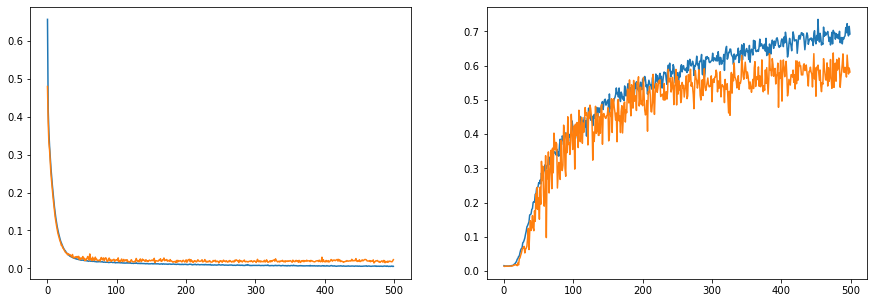

In [14]:
#df = pd.read_csv('./files/data.csv')
history = hist
fig, (ax_loss, ax_acc) = plt.subplots(1, 2, figsize=(15,5))
ax_loss.plot(history.epoch, history.history["loss"], label="Train loss")
ax_loss.plot(history.epoch, history.history["val_loss"], label="Validation loss")
ax_acc.plot(history.epoch, history.history["dice_coefficient"], label="Train accuracy")
ax_acc.plot(history.epoch, history.history["val_dice_coefficient"], label="Validation accuracy")

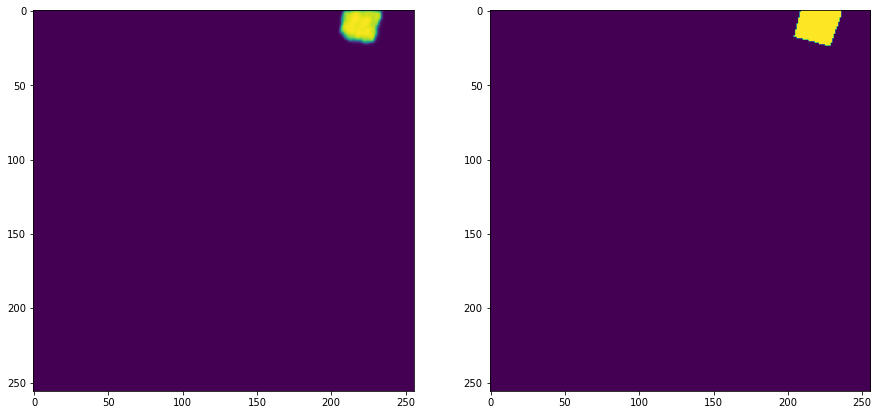

In [35]:
%matplotlib inline
from matplotlib import pyplot as plt

testImg = '../../ds/tiles_256_256_27_test/T40VEM_pair_4.tif_7987_5693_with_object.tif'
img = io.imread(testImg)/65536
            
            #flip = np.random.binomial(1, .5)
            #if flip > 0.5:
            #    img = cv2.flip(img, 1)
            
            # x with features
toPredict = np.array(
                np.dstack([
#img[:,:,21], # new red
                    #img[:,:,25], # new red
                    #img[:,:,26], # new red
                    
                    # separate new
                    img[:,:,4],
                    #img[:,:,5],
                    #img[:,:,6],
                    #img[:,:,7],
                    img[:,:,8],
                    #img[:,:,13],
                    # separate old
                    img[:,:,17],
                    #img[:,:,18],
                    #img[:,:,19],
                    #img[:,:,20],
                    img[:,:,21],
                    #img[:,:,26],
                    #
                    img[:,:,4] - img[:,:,17], # dif red
                    img[:,:,17] - img[:,:,4], # dif for transitionChange
                    #img[:,:,8],
                    #img[:,:,21],
                    #img[:,:,13],
                    img[:,:,8] - img[:,:,21],
                    img[:,:,21] - img[:,:,8],
                    #(
                    #    (img[:,:,8] - img[:,:,4]) /((img[:,:,8] + img[:,:,4])+ 0.0001)- # new ndvi
                    #    (img[:,:,21] - img[:,:,17])/((img[:,:,21] + img[:,:,17])+0.0001) # old ndvi
                    #), # ndvi diff
                    #swvi dif
                    #(
                    #    (img[:,:,8] - img[:,:,13]) /((img[:,:,8] + img[:,:,13])+0.0001)-   # new swir
                    #    (img[:,:,21] - img[:,:,26])/((img[:,:,21] + img[:,:,26])+0.0001)  # old swir
                        
                    #),
                    #swvi dif 
                    #(
                    #    (img[:,:,21] - img[:,:,26])/((img[:,:,21] + img[:,:,26])+0.0001) -
                    #    (img[:,:,8] - img[:,:,13]) /((img[:,:,8] + img[:,:,13])+0.0001)   # new swir
                         # old swir
                        
                    #),
                    
                    img[:,:,13],
                    img[:,:,26],
                    img[:,:,13] - img[:,:,26],
                    img[:,:,26] - img[:,:,13], # dif for transitionChange
                    img[:,:,12], # dif for transitionChange
                    img[:,:,25], # dif for transitionChange
                    img[:,:,12] - img[:,:,25], # dif for transitionChange
                    img[:,:,25] - img[:,:,12], # dif for transitionChange
                    #(get_value_by_extent(imagePath))/100.0
                    
                ]).astype('float32'))

testPrediction = model.predict(np.array([toPredict]))

#display output
fig,axes = plt.subplots(ncols=2,figsize=(15,15))

#display without probality condition
#axes[0].imshow(np.where(testPrediction[0].astype('float32')>0.5,1,0))

#display with probality condition
axes[0].imshow(testPrediction[0].astype('float32'))

axes[1].imshow(img[:,:,0])

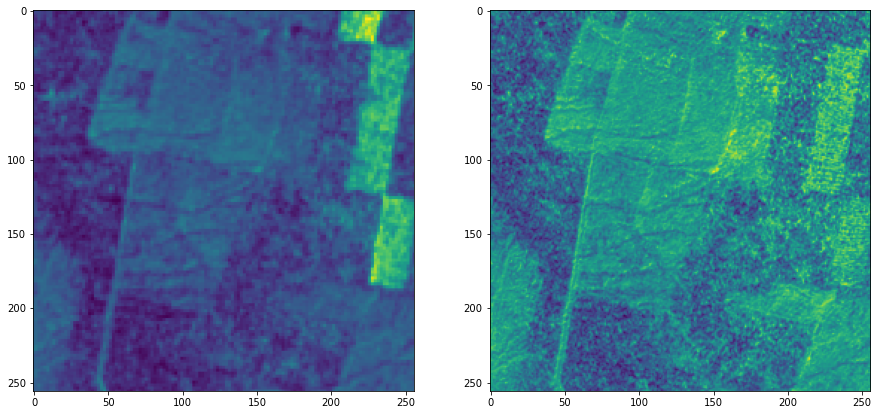

In [36]:
fig,axes = plt.subplots(ncols=2,figsize=(15,15))
#%matplotlib inline
#plt.imshow(testPredcition[0])
#axes[0].imshow((img[:,:,8] - img[:,:,13]) /((img[:,:,8] + img[:,:,13]) + 0.0001))
#axes[1].imshow((img[:,:,21] - img[:,:,26])/((img[:,:,21] + img[:,:,26])+ 0.0001))

axes[0].imshow(img[:,:,13])
axes[1].imshow(img[:,:,21])
#np.unique(testPrediction[0])

In [33]:
np.max(testPrediction[0])

0.0016177878

In [23]:
tf.keras.utils.plot_model(model)

Failed to import pydot. You must install pydot and graphviz for `pydotprint` to work.


In [78]:
train_generator = DataGenerator(allTifs[:-validSize],batch_size=batch)

In [281]:
df.iloc[0]

Unnamed: 0              1.000000
0.026183055713772774    0.025647
0.23869885504245758     0.095357
0.001                   0.001000
0.019560953602194786    0.018433
0.16562528908252716     0.076893
Name: 0, dtype: float64

In [79]:
len(train_generator[0][1])

32

# Custom data generator

In [5]:
import imgaug as ia
from imgaug import augmenters as iaa

class DataGenerator(tf.keras.utils.Sequence):
    """
    Custom data generator for Unet PermForestChange
    
    Main parameter is unputTiffs - list to path to tiff files
    
    Sample usage 
    allTifs = list(glob.glob('../../ds/tiles_256_256_27/*/*.tif'))

    validSize = 250
    
    train_generator = DataGenerator(allTifs[:-validSize],batch_size=batch)
    
    """
    def __init__(self, inputTiffs, batch_size=32, num_classes=2, shuffle=True):
        self.inputTiffs = inputTiffs
        self.batch_size = batch_size
        self.num_classes = num_classes
        self.shuffle = shuffle
        self.on_epoch_end()
        #custom augmentation with imgaug lib
        self.aug_pipe = iaa.Sequential(
            [
                iaa.SomeOf((0,2),
                [
                    #iaa.Add((-30, -10)), # change brightness of images (by -10 to 10 of original value)
                    #iaa.Multiply((0.8, 1.2)),
                    
                    # Geometric transfroms
                    iaa.Rotate((-45,45)),
                    iaa.TranslateX(px=(-20, 20)),
                    iaa.TranslateY(px=(-20, 20)),
                ]
                ),
            ],
            random_order=True
        )

    def __len__(self):
        return len(self.inputTiffs) // self.batch_size

    def __getitem__(self, index):
        indexes = self.index[index * self.batch_size:(index + 1) * self.batch_size]
        #print (indexes)
        batchTifs = [self.inputTiffs[k] for k in indexes]
        
        X, y = self._get_data(batchTifs)
        return X, y

    def on_epoch_end(self):
        self.index = np.arange(len(self.inputTiffs))
        if self.shuffle == True:
            np.random.shuffle(self.index)

    def _get_data(self, batch):
        #X = inArray
        #y = # logic
        
        X = []
        y = []
        
        for idx,imagePath in enumerate(batch):
            
            #print (image)
            
            # raw image
            img = (io.imread(imagePath)/65536).astype('float32')
            
            # flip with cv2
            #flip = np.random.binomial(1, .5)
            #if flip > 0.5:
                #img = self.flip(img)
            
            # aug with imgaug lib
            #img = self.aug_pipe.augment_image(img)
            
            # x with features
            # channel indexes
            # mask - 0 
            # NEW
            #["B01","B02","B03","B04","B05","B06","B07","B08","B8A","B09","B10","B11","B12"]
            #[ 1,     2,    3,    4,    5,    6,    7,    8,    9,    10,   11,   12,   13  ]
            # OLD
            #["B01","B02","B03","B04","B05","B06","B07","B08","B8A","B09","B10","B11","B12"]
            #[ 14,    15,   16,   17,   18,   19,   20,   21,   22,   23,   24,   25,   26  ]
            X.append(np.array(
                np.dstack([
#img[:,:,17],# old red
                    #img[:,:,21], # new red
                    #img[:,:,25], # new red
                    #img[:,:,26], # new red
                    
                    # separate new
                    img[:,:,4],
                    #img[:,:,5],
                    #img[:,:,6],
                    #img[:,:,7],
                    img[:,:,8],
                    #img[:,:,13],
                    # separate old
                    img[:,:,17],
                    #img[:,:,18],
                    #img[:,:,19],
                    #img[:,:,20],
                    img[:,:,21],
                    #img[:,:,26],
                    #
                    img[:,:,4] - img[:,:,17], # dif red
                    img[:,:,17] - img[:,:,4], # dif for transitionChange
                    #img[:,:,8],
                    #img[:,:,21],
                    #img[:,:,13],
                    img[:,:,8] - img[:,:,21],
                    img[:,:,21] - img[:,:,8],
                    #(
                    #    (img[:,:,8] - img[:,:,4]) /((img[:,:,8] + img[:,:,4])+ 0.0001)- # new ndvi
                    #    (img[:,:,21] - img[:,:,17])/((img[:,:,21] + img[:,:,17])+0.0001) # old ndvi
                    #), # ndvi diff
                    #swvi dif
                    #(
                    #    (img[:,:,8] - img[:,:,13]) /((img[:,:,8] + img[:,:,13])+0.0001)-   # new swir
                    #    (img[:,:,21] - img[:,:,26])/((img[:,:,21] + img[:,:,26])+0.0001)  # old swir
                        
                    #),
                    #swvi dif 
                    #(
                    #    (img[:,:,21] - img[:,:,26])/((img[:,:,21] + img[:,:,26])+0.0001) -
                    #    (img[:,:,8] - img[:,:,13]) /((img[:,:,8] + img[:,:,13])+0.0001)   # new swir
                         # old swir
                        
                    #),
                    
                    img[:,:,13],
                    img[:,:,26],
                    img[:,:,13] - img[:,:,26],
                    img[:,:,26] - img[:,:,13], # dif for transitionChange
                    img[:,:,12], # dif for transitionChange
                    img[:,:,25], # dif for transitionChange
                    img[:,:,12] - img[:,:,25], # dif for transitionChange
                    img[:,:,25] - img[:,:,12], # dif for transitionChange
                    #(get_value_by_extent(imagePath))/100.0
                    
                    
                ])).astype('float32'))
            
            # to one class all changes
            y.append(np.where(img[:,:,0]>0,1,0).astype('int'))
            
        return np.array(X), np.array(y)
    
    def flip(self,image):
        """
        Random flip image around x, y or both axes
        image is np.array
        """
        flipDirection = np.random.randint(-1,1,1)[0]
        return cv2.flip(image,flipDirection)
        
        

In [225]:
testGen = DataGenerator(list(glob.glob('../../ds/tiles_256_256_27/*/*.tif')),batch_size=32)

In [226]:
len(testGen)

106

In [229]:
np.max(testGen[batchNum][0][imgIdx][:,:,3])

[3026  847  869  231 1280  951 2401 1678  889 2725 1275 2745 1075 1520
  420 1431  433 2128 1695 2783 1759 1731 1905 2608 2327 1468  393 2027
 2930  203  720 1191]


0.06152

In [42]:
from matplotlib import pyplot as plt

imgIdx = 0
batchNum = 2
testImg = (testGen[batchNum][0][imgIdx][:,:,1]*65536)
testMask = testGen[batchNum][1][imgIdx]
#print(testImg.shape,testMask.shape)
fig,axes = plt.subplots(ncols=2,figsize=(15,15))
axes[0].imshow(testImg)
axes[1].imshow(testMask)

NameError: name 'testGen' is not defined

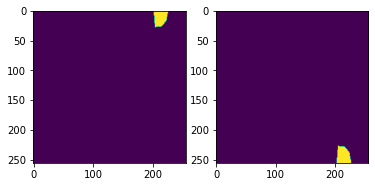

In [15]:
from matplotlib import pyplot as plt
import glob
import cv2
from skimage import io
testFlipImage = list(glob.glob('../../ds/tiles_256_256_27/*/*.tif'))[0]
img = io.imread(testFlipImage)
flipped=cv2.flip(img,0)
fig,axes = plt.subplots(ncols=2)
axes[0].imshow(flipped[:,:,0])
axes[1].imshow(img[:,:,0])

In [32]:
img = io.imread('../../ds/tiles_256_256_27/T39VVJ_pair_0.tif/'+
                   'T39VVJ_pair_0.tif_10091_3559_with_object.tif')

In [2]:
tempCalck = np.array(
                np.dstack([
                    img[:,:,17],# old red
                    img[:,:,4], # new red
                    img[:,:,4] - img[:,:,17], # dif
                    img[:,:,8],
                    img[:,:,21],
                    img[:,:,8] - img[:,:,21],
                    (
                        (img[:,:,21] - img[:,:,17])/(img[:,:,21] + img[:,:,17])-
                        (img[:,:,8] - img[:,:,4])/ (img[:,:,8] + img[:,:,4])
                        
                    ), # ndvi diff
                    
                ])).astype('float32')

NameError: name 'np' is not defined

In [ ]:
%matplotlib inline
plt.imshow(tempCalck[:,:,6].astype('float32'))

In [47]:
(img[:,:,21] - img[:,:,17])/(img[:,:,21] + img[:,:,17])

array([[0.11824394, 0.11828825, 0.13282556, ..., 0.15109296, 0.15732648,
        0.13275271],
       [0.12171332, 0.12021519, 0.11128588, ..., 0.13801694, 0.11950697,
        0.10991669],
       [0.12847682, 0.11763472, 0.11460488, ..., 0.13073852, 0.10353936,
        0.10635042],
       ...,
       [0.17748918, 0.18011758, 0.16649378, ..., 0.12227896, 0.14371749,
        0.1702292 ],
       [0.17508583, 0.17726887, 0.19292517, ..., 0.11939492, 0.15245478,
        0.16315933],
       [0.14742015, 0.21019457, 0.1485426 , ..., 0.13832553, 0.13329876,
        0.12221672]])

In [4]:
import glob
list(glob.glob('../../ds/tiles_256_256_27/*/*with_object.tif'))

['../../ds/tiles_256_256_27/T39VVJ_pair_0.tif/T39VVJ_pair_0.tif_749_8648_with_object.tif',
 '../../ds/tiles_256_256_27/T39VVJ_pair_0.tif/T39VVJ_pair_0.tif_685_8649_with_object.tif',
 '../../ds/tiles_256_256_27/T39VVJ_pair_0.tif/T39VVJ_pair_0.tif_1897_9329_with_object.tif',
 '../../ds/tiles_256_256_27/T39VVJ_pair_0.tif/T39VVJ_pair_0.tif_2338_6774_with_object.tif',
 '../../ds/tiles_256_256_27/T39VVJ_pair_0.tif/T39VVJ_pair_0.tif_2390_9789_with_object.tif',
 '../../ds/tiles_256_256_27/T39VVJ_pair_0.tif/T39VVJ_pair_0.tif_3273_5181_with_object.tif',
 '../../ds/tiles_256_256_27/T39VVJ_pair_0.tif/T39VVJ_pair_0.tif_3350_9754_with_object.tif',
 '../../ds/tiles_256_256_27/T39VVJ_pair_0.tif/T39VVJ_pair_0.tif_5243_7308_with_object.tif',
 '../../ds/tiles_256_256_27/T39VVJ_pair_0.tif/T39VVJ_pair_0.tif_5845_10641_with_object.tif',
 '../../ds/tiles_256_256_27/T39VVJ_pair_0.tif/T39VVJ_pair_0.tif_5978_10836_with_object.tif',
 '../../ds/tiles_256_256_27/T39VVJ_pair_0.tif/T39VVJ_pair_0.tif_6158_5891_with_o

# Cosine learning rate

In [ ]:
import numpy as np
import tensorflow.keras as keras
from tensorflow.keras import backend as K
from tensorflow.keras.callbacks import (
    Callback,
    LearningRateScheduler,
    TensorBoard
)


class WarmUpCosineDecayScheduler(keras.callbacks.Callback):
    """Cosine decay with warmup learning rate scheduler
    """
    def __init__(self,
                 learning_rate_base,
                 global_step_init=0,
                 warmup_learning_rate=0.0,
                 warmup_epoch=0,
                 hold_base_rate_steps=0,
                 learning_rate_final=None,
                 stop_epoch=None,
                 verbose=0):
        """Constructor for cosine decay with warmup learning rate scheduler.
        Arguments:
            learning_rate_base {float} -- base learning rate.
            total_steps {int} -- total number of training steps.
        Keyword Arguments:
            global_step_init {int} -- initial global step, e.g. from previous checkpoint.
            warmup_learning_rate {float} -- initial learning rate for warm up. (default: {0.0})
            warmup_steps {int} -- number of warmup steps. (default: {0})
            hold_base_rate_steps {int} -- Optional number of steps to hold base learning rate
                                        before decaying. (default: {0})
            verbose {int} -- 0: quiet, 1: update messages. (default: {0})
        """

        super(WarmUpCosineDecayScheduler, self).__init__()
        self.learning_rate_base = learning_rate_base
        self.global_step = global_step_init
        self.warmup_learning_rate = warmup_learning_rate
        self.warmup_epoch = warmup_epoch
        self.hold_base_rate_steps = hold_base_rate_steps
        self.learning_rates = []
        self.verbose = verbose
        self.stop_epoch = stop_epoch
        self.learning_rate_final = learning_rate_final
        self.epoch = 0

    def on_epoch_begin(self, epoch, logs=None):
        self.epoch = epoch

    def on_batch_end(self, batch, logs=None):
        self.global_step = self.global_step + 1
        lr = K.get_value(self.model.optimizer.lr)
        self.learning_rates.append(lr)

    def on_batch_begin(self, batch, logs=None):
        total_steps = int(
            self.params['epochs'] * self.params['samples'] / self.params['batch_size'])
        warmup_steps = int(
            self.warmup_epoch * self.params['samples']  / self.params['batch_size'])
        lr = self.cosine_decay_with_warmup(
            global_step=self.global_step,
            learning_rate_base=self.learning_rate_base,
            total_steps=total_steps,
            warmup_learning_rate=self.warmup_learning_rate,
            warmup_steps=warmup_steps,
            hold_base_rate_steps=self.hold_base_rate_steps)
        if self.stop_epoch is not None and self.stop_epoch > 0 and self.epoch >= self.stop_epoch:
            if self.learning_rate_final is not None:
                K.set_value(self.model.optimizer.lr, self.learning_rate_final)
            else:
                self.learning_rate_final = lr
                K.set_value(self.model.optimizer.lr, self.learning_rate_final)
        else:
            K.set_value(self.model.optimizer.lr, lr)
        if self.verbose > 0:
            print('\nBatch %05d: setting learning '
                  'rate to %s.' % (self.global_step + 1, lr))

    def cosine_decay_with_warmup(self, global_step,
                                 learning_rate_base,
                                 total_steps,
                                 warmup_learning_rate=0.0,
                                 warmup_steps=0,
                                 hold_base_rate_steps=0):
        """Cosine decay schedule with warm up period.
        Cosine annealing learning rate as described in
            Loshchilov and Hutter, SGDR: Stochastic Gradient Descent with Warm Restarts.
            ICLR 2017. https://arxiv.org/abs/1608.03983
        In this schedule, the learning rate grows linearly from warmup_learning_rate
        to learning_rate_base for warmup_steps, then transitions to a cosine decay
        schedule.
        Arguments:
            global_step {int} -- global step.
            learning_rate_base {float} -- base learning rate.
            total_steps {int} -- total number of training steps.
        Keyword Arguments:
            warmup_learning_rate {float} -- initial learning rate for warm up. (default: {0.0})
            warmup_steps {int} -- number of warmup steps. (default: {0})
            hold_base_rate_steps {int} -- Optional number of steps to hold base learning rate
                                        before decaying. (default: {0})
        Returns:
            a float representing learning rate.
        Raises:
            ValueError: if warmup_learning_rate is larger than learning_rate_base,
            or if warmup_steps is larger than total_steps.
        """
        if total_steps < warmup_steps:
            raise ValueError('total_steps must be larger or equal to '
                             'warmup_steps.')
        learning_rate = 0.5 * learning_rate_base * (
            1 + np.cos(
                np.pi * (global_step - warmup_steps - hold_base_rate_steps) /
                float(total_steps - warmup_steps - hold_base_rate_steps)
                )
            )
        if hold_base_rate_steps > 0:
            learning_rate = np.where(global_step > warmup_steps + hold_base_rate_steps,
                                     learning_rate, learning_rate_base)
        if warmup_steps > 0:
            if learning_rate_base < warmup_learning_rate:
                raise ValueError('learning_rate_base must be larger or equal to '
                                 'warmup_learning_rate.')
            slope = (learning_rate_base - warmup_learning_rate) / warmup_steps
            warmup_rate = slope * global_step + warmup_learning_rate
            learning_rate = np.where(global_step < warmup_steps, warmup_rate,
                                     learning_rate)
        return np.where(global_step > total_steps, 0.0, learning_rate)